In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph,END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=init_chat_model('groq:gemma2-9b-it')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fe712cafaa0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fe71264aff0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
urls=[
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2023-04-22-diffusion-video/'
]

docs=[]
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
chunks=splitter.split_documents(docs)

vectorStore=FAISS.from_documents(chunks,OpenAIEmbeddings(model='text-embedding-3-small'))
retriever=vectorStore.as_retriever()

In [4]:
class RAGState(BaseModel):
    question:str
    sub_question:List[str]=[]
    retrieved_docs:List[Document]=[]
    answer:str=""

In [5]:
def plan_query(state:RAGState) -> RAGState:
    prompt=f"""Break the following complex question into 2-3 sub-questions:
    Question:{state.question}
    Sub-question:
    """

    result=llm.invoke(prompt)
    sub_questions=[line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question,sub_question=sub_questions)



def retrieve_for_each(state:RAGState)->RAGState:
    all_docs=[]
    for sub in state.sub_question:
        docs=retriever.invoke(sub)
        all_docs.extend(docs)

    return RAGState(question=state.question,sub_question=state.sub_question,retrieved_docs=all_docs)


def generate_final_answer(state:RAGState) -> RAGState:
    context="\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt=f"""Use the context below to answer the question.
    context:{context}\n\n question:{state.question}"""

    answer=llm.invoke(prompt).content
    return RAGState(question=state.question,sub_question=state.sub_question,retrieved_docs=state.retrieved_docs,answer=answer)

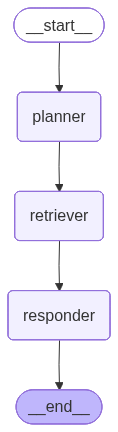

In [6]:
builder=StateGraph(RAGState)

builder.add_node('planner',plan_query)
builder.add_node('retriever',retrieve_for_each)
builder.add_node('responder',generate_final_answer)

builder.set_entry_point('planner')
builder.add_edge('planner','retriever')
builder.add_edge('retriever','responder')
builder.add_edge('responder',END)

graph=builder.compile()
graph

In [8]:
if __name__=="__main__":
    query="How basically attention mechansim changed the overview of recurrent models and what was dominated the sequence modeling before attention mechanism? "
    init_state=RAGState(question=query)
    result=graph.invoke(init_state)
    print(result)

    print("\n Sub-questions")

    for question in result['sub_question']:
        print("-",question)

    
    print("\nFinal Answer:",result['answer'])


{'question': 'How basically attention mechansim changed the overview of recurrent models and what was dominated the sequence modeling before attention mechanism? ', 'sub_question': ['Here are some sub-questions that break down the complex query:', '* **Sub-question 1:** What were the limitations of recurrent models (like RNNs) in handling long sequences before the introduction of attention mechanisms?', '* **Sub-question 2:** How do attention mechanisms address these limitations and improve the performance of sequence modeling tasks?', '* **Sub-question 3:** What were the dominant sequence modeling approaches before attention mechanisms gained popularity? (This could explore methods like traditional RNNs, convolutional networks for sequences, etc.)', "Let me know if you'd like to explore any of these sub-questions in more detail!"], 'retrieved_docs': [Document(id='041242b2-ea53-4a9b-b861-51e06f1a89bc', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title':